In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import re
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('bollywood_data.csv')
df

,title_x,imdb_id,poster_path,wiki_link,title_y,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date,budget,box office
0,Uri: The Surgical Strike,tt8291224,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Uri:_The_Surgica...,Uri: The Surgical Strike,Uri: The Surgical Strike,0,2019,138,Action|Drama|War,8.4,35112,Divided over five chapters the film chronicles...,Indian army special forces execute a covert op...,NaN,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4 wins,11 January 2019 (USA),25.00,342.06
1,Battalion 609,tt9472208,NaN,https://en.wikipedia.org/wiki/Battalion_609,Battalion 609,Battalion 609,0,2019,131,War,4.1,73,The story revolves around a cricket match betw...,The story of Battalion 609 revolves around a c...,NaN,Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...,NaN,11 January 2019 (India),0.01,2.70
2,The Accidental Prime Minister (film),tt6986710,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/The_Accidental_P...,The Accidental Prime Minister,The Accidental Prime Minister,0,2019,112,Biography|Drama,6.1,5549,Based on the memoir by Indian policy analyst S...,Explores Manmohan Singh's tenure as the Prime ...,NaN,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,NaN,11 January 2019 (USA),18.00,22.65
3,Why Cheat India,tt8108208,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Why_Cheat_India,Why Cheat India,Why Cheat India,0,2019,121,Crime|Drama,6.0,1891,The movie focuses on existing malpractices in ...,The movie focuses on existing malpractices in ...,NaN,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,NaN,18 January 2019 (USA),20.00,10.54
4,Evening Shadows,tt6028796,NaN,https://en.wikipedia.org/wiki/Evening_Shadows,Evening Shadows,Evening Shadows,0,2018,102,Drama,7.3,280,While gay rights and marriage equality has bee...,Under the 'Evening Shadows' truth often plays ...,NaN,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 wins & 1 nomination,11 January 2019 (India),2.75,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,Samadhi (1950 film),tt0268614,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Samadhi_(1950_film),Samadhi,Samadhi,0,1950,165,Drama,6.1,21,The story is based on the true incident at INA...,The story is based on the true incident at INA...,NaN,Ashok Kumar|Nalini Jaywant|Kuldip Kaur|Shyam|M...,NaN,NaN,NaN,NaN
4325,Sangram (1950 film),tt0244182,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sangram_(1950_film),Sangram,Sangram,0,1950,139,Drama,6.2,20,After the death of his wife a policeman fails ...,After the death of his wife a policeman fails ...,NaN,Ashok Kumar|Nalini Jaywant|Nawab|Sajjan|Tiwari...,NaN,NaN,NaN,NaN
4326,Sargam (1950 film),tt0269826,NaN,https://en.wikipedia.org/wiki/Sargam_(1950_film),Melody,Sargam,0,1950,135,Drama|Family,6.8,21,NaN,Add a Plot »,NaN,Raj Kapoor|Rehana|Om Prakash|David Abraham|Rad...,NaN,4 February 1957 (Iran),NaN,NaN
4327,Sheesh Mahal (1950 film),tt0243555,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sheesh_Mahal_(19...,Sheesh Mahal,Sheesh Mahal,0,1950,144,Drama,7.0,13,Thakur Jaspal Singh lives in the prestigious a...,Thakur Jaspal Singh lives in the prestigious a...,NaN,Sohrab Modi|Naseem Banu|Pushpa Hans|Nigar Sult...,NaN,NaN,NaN,NaN


In [3]:
#Droping columns which are not useful
df = df.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [4]:
#Renaming columns for ease of references
df = df.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})


In [5]:
#Data cleaning
df['awards'] = df['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

df[['wins', 'nominations']] = df.awards.str.split('&', expand= True)

df['wins'] = df['wins'].str.strip()
df['wins'] = df['wins'].apply(lambda x: 0 if x=='' else x)
df['wins'] = df['wins'].replace(np.nan, 0)
df['wins'] = df['wins'].astype(int)

df['runtime'] = df['runtime'].replace('\\N', np.nan)
df['runtime'] = df['runtime'].ffill()
df['runtime'] = df['runtime'].astype(int)
df = df[df['runtime'] >= 60]

actors = df.actors.str.split('|', expand=True)
df['lead_actor'] = actors[0]

df[['genre', 'genre2', 'genre3']] = df.genres.str.split("|", expand=True)
df[['lead_actor1', 'lead_actor2', 'lead_actor3', 'lead_actor4']] = df.actors.str.split("|", expand=True)[[0,1,2,3]]
df.drop(['genres', 'awards', 'actors', 'genre2', 'genre3', 'nominations'], axis=1)
minor_genre_list = ['Animation', 'Documentary', 'History', 'Music', 'War', 'Sci-Fi', 'Sport']
df = df[~df['genre'].isin(minor_genre_list)]

df = df.drop(['awards', 'genres','lead_actor','actors'], axis=1)
df = df[df['year'] >= 2009]
df = df.drop_duplicates()

In [6]:
df['nominations'] = df['nominations'].fillna(0)
df['genre'] = df['genre'].fillna(0)
df['genre2'] = df['genre2'].fillna(0)
df['genre3'] = df['genre3'].fillna(0)


In [7]:
#df['year'] = df['year'].astype(str)
#df['NumLeadActor'] = df['NumLeadActor'].astype(str)

In [8]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df['year'] = df['year'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 973
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        961 non-null    object 
 1   year         961 non-null    int64  
 2   runtime      961 non-null    int32  
 3   rating       961 non-null    float64
 4   votes        961 non-null    int64  
 5   budget       961 non-null    float64
 6   box office   961 non-null    float64
 7   wins         961 non-null    int32  
 8   nominations  961 non-null    object 
 9   genre        961 non-null    object 
 10  genre2       961 non-null    object 
 11  genre3       961 non-null    object 
 12  lead_actor1  960 non-null    object 
 13  lead_actor2  960 non-null    object 
 14  lead_actor3  943 non-null    object 
 15  lead_actor4  906 non-null    object 
dtypes: float64(3), int32(2), int64(2), object(9)
memory usage: 120.1+ KB


In [9]:
d = {df.lead_actor1.unique()[i] : i for i in range(len(df.lead_actor1.unique()))}
actor_list = list(d.items())
actor_list1 = np.array(actor_list).reshape(-1,2)
df["NumLeadActor"] = [d[i] for i in df['lead_actor1']]
df

,title,year,runtime,rating,votes,budget,box office,wins,nominations,genre,genre2,genre3,lead_actor1,lead_actor2,lead_actor3,lead_actor4,NumLeadActor
0,Uri: The Surgical Strike,2019,138,8.4,35112,25.00,342.06,4,0,Action,Drama,War,Vicky Kaushal,Paresh Rawal,Mohit Raina,Yami Gautam,0
2,The Accidental Prime Minister,2019,112,6.1,5549,18.00,22.65,0,0,Biography,Drama,0,Anupam Kher,Akshaye Khanna,Aahana Kumra,Atul Sharma,1
3,Why Cheat India,2019,121,6.0,1891,20.00,10.54,0,0,Crime,Drama,0,Emraan Hashmi,Shreya Dhanwanthary,Snighdadeep Chatterji,Navneet Srivastava,2
4,Evening Shadows,2018,102,7.3,280,2.75,2.50,17,1,Drama,0,0,Mona Ambegaonkar,Ananth Narayan Mahadevan,Devansh Doshi,Arpit Chaudhary,3
5,Soni,2018,97,7.2,1595,0.50,0.10,3,5,Drama,0,0,Geetika Vidya Ohlyan,Saloni Batra,Vikas Shukla,Mohit Chauhan,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,4.0,7266,80.00,120.00,1,3,Action,Comedy,0,Mithun Chakraborty,Akshay Kumar,Deepika Padukone,Ranvir Shorey,345
970,Familywala,2014,180,5.8,57,6.00,3.00,0,0,Comedy,Drama,Romance,Arjun Rampal,Dia Mirza,Ashok Saraf,Shoma Anand,143
971,Sunglass,2013,100,6.5,24,8.00,5.00,0,0,Comedy,Drama,Thriller,Jaya Bachchan,Madhavan,Tota Roy Chowdhury,Raima Sen,446
972,Sabse Bada Sukh,2018,100,6.1,13,10.00,7.00,0,0,Comedy,Drama,0,Vijay Arora,Asrani,Rajni Bala,Kumud Damle,447


In [10]:
df.shape

(961, 17)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 973
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         961 non-null    object 
 1   year          961 non-null    int64  
 2   runtime       961 non-null    int32  
 3   rating        961 non-null    float64
 4   votes         961 non-null    int64  
 5   budget        961 non-null    float64
 6   box office    961 non-null    float64
 7   wins          961 non-null    int32  
 8   nominations   961 non-null    object 
 9   genre         961 non-null    object 
 10  genre2        961 non-null    object 
 11  genre3        961 non-null    object 
 12  lead_actor1   960 non-null    object 
 13  lead_actor2   960 non-null    object 
 14  lead_actor3   943 non-null    object 
 15  lead_actor4   906 non-null    object 
 16  NumLeadActor  961 non-null    int64  
dtypes: float64(3), int32(2), int64(3), object(9)
memory usage: 127.6+ KB


In [12]:
df.isnull().sum()

title            0
year             0
runtime          0
rating           0
votes            0
budget           0
box office       0
wins             0
nominations      0
genre            0
genre2           0
genre3           0
lead_actor1      1
lead_actor2      1
lead_actor3     18
lead_actor4     55
NumLeadActor     0
dtype: int64

In [13]:
df.describe()

,year,runtime,rating,votes,budget,box office,wins,NumLeadActor
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,2014.082206,128.284079,5.657128,6234.078044,24.970583,49.955169,2.423517,153.552549
std,2.991743,21.707992,1.587672,16068.517719,33.602508,116.521245,6.109814,129.492437
min,2009.000000,79.000000,0.000000,0.000000,0.070000,0.000800,0.000000,0.000000
25%,2012.000000,114.000000,4.600000,270.000000,5.250000,1.000000,0.000000,41.000000
50%,2014.000000,128.000000,5.700000,1373.000000,14.000000,9.990000,0.000000,112.000000
75%,2017.000000,140.000000,6.900000,5524.000000,30.000000,49.000000,2.000000,255.000000
max,2019.000000,321.000000,9.400000,310481.000000,350.000000,2100.000000,57.000000,448.000000


Correlation

In [14]:
correlation = df.corr()
correlation

,year,runtime,rating,votes,budget,box office,wins,NumLeadActor
year,1.000000,-0.023825,0.094429,-0.023959,0.143226,0.120566,-0.067442,-0.440415
runtime,-0.023825,1.000000,0.031593,0.322358,0.422520,0.320297,0.235139,-0.192207
rating,0.094429,0.031593,1.000000,0.307923,0.004134,0.183980,0.309701,-0.114880
votes,-0.023959,0.322358,0.307923,1.000000,0.337082,0.573959,0.631573,-0.178853
budget,0.143226,0.422520,0.004134,0.337082,1.000000,0.588879,0.284765,-0.298859
box office,0.120566,0.320297,0.183980,0.573959,0.588879,1.000000,0.454319,-0.231516
wins,-0.067442,0.235139,0.309701,0.631573,0.284765,0.454319,1.000000,-0.163753
NumLeadActor,-0.440415,-0.192207,-0.114880,-0.178853,-0.298859,-0.231516,-0.163753,1.000000


<AxesSubplot:>

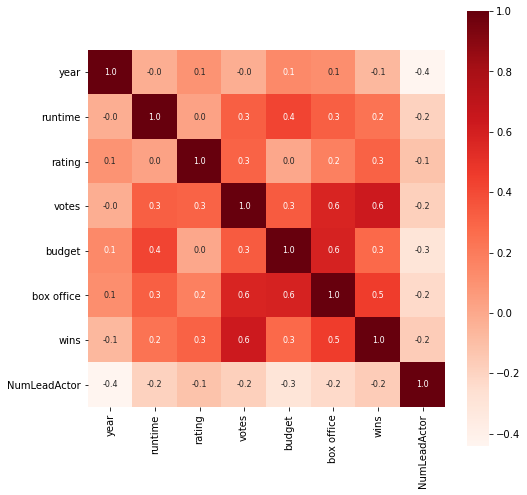

In [15]:
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Reds')

In [16]:
#correalation values of box office
print(correlation['box office'])

year            0.120566
runtime         0.320297
rating          0.183980
votes           0.573959
budget          0.588879
box office      1.000000
wins            0.454319
NumLeadActor   -0.231516
Name: box office, dtype: float64


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='box office', ylabel='Density'>

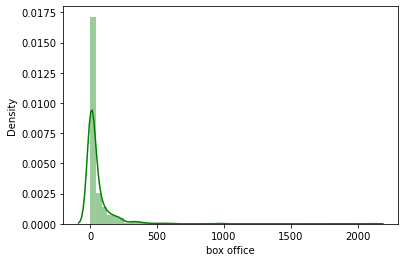

In [17]:
#checking the distribution of box office
sns.distplot(df['box office'], color='green')

In [18]:
X = df.drop(['year', 'NumLeadActor', 'title', 'genre', 'genre2', 'genre3', 'lead_actor1', 'lead_actor2', 'lead_actor3', 'lead_actor4'], axis=1)
Y = df['box office']

In [19]:
print(X)

     runtime  rating  votes  budget  box office  wins nominations
0        138     8.4  35112   25.00      342.06     4           0
2        112     6.1   5549   18.00       22.65     0           0
3        121     6.0   1891   20.00       10.54     0           0
4        102     7.3    280    2.75        2.50    17          1 
5         97     7.2   1595    0.50        0.10     3          5 
..       ...     ...    ...     ...         ...   ...         ...
969      154     4.0   7266   80.00      120.00     1          3 
970      180     5.8     57    6.00        3.00     0           0
971      100     6.5     24    8.00        5.00     0           0
972      100     6.1     13   10.00        7.00     0           0
973      136     7.4     38   12.00       20.00     0           0

[961 rows x 7 columns]


In [20]:
print(Y)

0      342.06
2       22.65
3       10.54
4        2.50
5        0.10
        ...  
969    120.00
970      3.00
971      5.00
972      7.00
973     20.00
Name: box office, Length: 961, dtype: float64


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Random Forest Regressor

In [22]:
regressor = RandomForestRegressor(n_estimators=100)

In [23]:
#training the model
regressor.fit(X_train, Y_train)

RandomForestRegressor()

In [24]:
#prediction on test data
test_data_prediction = regressor.predict(X_test)

In [25]:
print(test_data_prediction)

[1.343320e+00 2.263170e+01 1.529425e+02 1.989650e+01 2.899540e+01
 1.365530e+01 1.884000e-02 8.296000e-02 2.013200e+00 1.715750e+02
 2.025000e-01 8.641200e+00 6.408000e-01 2.587650e+01 2.675200e+01
 3.192800e+00 3.441900e+00 4.329658e+02 6.057000e-01 2.797500e-01
 6.688500e+00 3.980000e-02 2.167500e+00 3.249100e+00 1.856100e+00
 4.988600e+00 4.117940e+01 6.566400e+01 1.298060e+00 6.735000e-01
 3.952050e+01 7.223010e+01 3.445900e+00 2.231200e+00 5.010000e-02
 1.561200e+00 2.090355e+02 1.053850e+01 8.159400e+00 1.982240e+01
 1.742940e+01 1.402494e+02 4.793780e+01 5.256010e+01 2.199000e-01
 1.836600e+00 1.192200e-01 4.463000e-03 3.390000e-01 1.148360e+01
 9.933000e-01 3.537410e+01 2.034000e-01 2.447800e+00 1.025306e+02
 1.503000e-01 1.710620e+01 3.910000e-02 9.394800e+00 8.201900e+01
 3.120000e-02 1.962500e+00 4.322900e+00 1.788700e+00 1.199862e+02
 4.645020e+01 1.087200e+00 2.101919e+02 4.320000e-01 9.834900e+00
 4.629360e+01 1.413200e-01 1.850000e-02 3.975000e-01 1.203400e-01
 4.494000e

In [26]:
# R sqared error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R sqared error : ", error_score)

R sqared error :  0.9910650635443193


Compare actual values and predicted values in a plot

In [27]:
Y_test = list(Y_test)

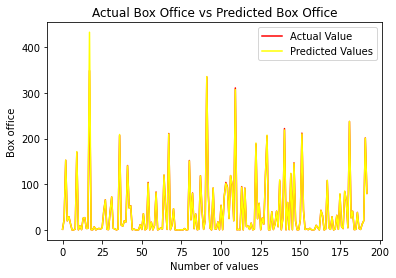

In [28]:
plt.plot(Y_test, color='red', label = 'Actual Value')
plt.plot(test_data_prediction, color='yellow', label='Predicted Values')
plt.title('Actual Box Office vs Predicted Box Office')
plt.xlabel('Number of values')
plt.ylabel('Box office')
plt.legend()
plt.show()

# Genres Splitting

In [29]:
genres_df = pd.read_csv('bollywood_data.csv')
genres_df


,title_x,imdb_id,poster_path,wiki_link,title_y,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date,budget,box office
0,Uri: The Surgical Strike,tt8291224,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Uri:_The_Surgica...,Uri: The Surgical Strike,Uri: The Surgical Strike,0,2019,138,Action|Drama|War,8.4,35112,Divided over five chapters the film chronicles...,Indian army special forces execute a covert op...,NaN,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4 wins,11 January 2019 (USA),25.00,342.06
1,Battalion 609,tt9472208,NaN,https://en.wikipedia.org/wiki/Battalion_609,Battalion 609,Battalion 609,0,2019,131,War,4.1,73,The story revolves around a cricket match betw...,The story of Battalion 609 revolves around a c...,NaN,Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...,NaN,11 January 2019 (India),0.01,2.70
2,The Accidental Prime Minister (film),tt6986710,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/The_Accidental_P...,The Accidental Prime Minister,The Accidental Prime Minister,0,2019,112,Biography|Drama,6.1,5549,Based on the memoir by Indian policy analyst S...,Explores Manmohan Singh's tenure as the Prime ...,NaN,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,NaN,11 January 2019 (USA),18.00,22.65
3,Why Cheat India,tt8108208,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Why_Cheat_India,Why Cheat India,Why Cheat India,0,2019,121,Crime|Drama,6.0,1891,The movie focuses on existing malpractices in ...,The movie focuses on existing malpractices in ...,NaN,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,NaN,18 January 2019 (USA),20.00,10.54
4,Evening Shadows,tt6028796,NaN,https://en.wikipedia.org/wiki/Evening_Shadows,Evening Shadows,Evening Shadows,0,2018,102,Drama,7.3,280,While gay rights and marriage equality has bee...,Under the 'Evening Shadows' truth often plays ...,NaN,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 wins & 1 nomination,11 January 2019 (India),2.75,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,Samadhi (1950 film),tt0268614,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Samadhi_(1950_film),Samadhi,Samadhi,0,1950,165,Drama,6.1,21,The story is based on the true incident at INA...,The story is based on the true incident at INA...,NaN,Ashok Kumar|Nalini Jaywant|Kuldip Kaur|Shyam|M...,NaN,NaN,NaN,NaN
4325,Sangram (1950 film),tt0244182,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sangram_(1950_film),Sangram,Sangram,0,1950,139,Drama,6.2,20,After the death of his wife a policeman fails ...,After the death of his wife a policeman fails ...,NaN,Ashok Kumar|Nalini Jaywant|Nawab|Sajjan|Tiwari...,NaN,NaN,NaN,NaN
4326,Sargam (1950 film),tt0269826,NaN,https://en.wikipedia.org/wiki/Sargam_(1950_film),Melody,Sargam,0,1950,135,Drama|Family,6.8,21,NaN,Add a Plot »,NaN,Raj Kapoor|Rehana|Om Prakash|David Abraham|Rad...,NaN,4 February 1957 (Iran),NaN,NaN
4327,Sheesh Mahal (1950 film),tt0243555,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sheesh_Mahal_(19...,Sheesh Mahal,Sheesh Mahal,0,1950,144,Drama,7.0,13,Thakur Jaspal Singh lives in the prestigious a...,Thakur Jaspal Singh lives in the prestigious a...,NaN,Sohrab Modi|Naseem Banu|Pushpa Hans|Nigar Sult...,NaN,NaN,NaN,NaN


In [30]:
#Droping columns which are not useful
genres_df = genres_df.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [31]:
#Renaming columns for ease of references
genres_df = genres_df.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})


In [32]:
#Data cleaning
genres_df['awards'] = genres_df['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

genres_df[['wins', 'nominations']] = genres_df.awards.str.split('&', expand= True)

genres_df['wins'] = genres_df['wins'].str.strip()
genres_df['wins'] = genres_df['wins'].apply(lambda x: 0 if x=='' else x)
genres_df['wins'] = genres_df['wins'].replace(np.nan, 0)
genres_df['wins'] =genres_df['wins'].astype(int)

genres_df['nominations'] = genres_df['nominations'].replace(np.nan, 0)
genres_df['nominations'] =genres_df['nominations'].astype(int)

genres_df['runtime'] = genres_df['runtime'].replace('\\N', np.nan)
genres_df['runtime'] = genres_df['runtime'].ffill()
genres_df['runtime'] = genres_df['runtime'].astype(int)
genres_df = genres_df[genres_df['runtime'] >= 60]

actors = genres_df.actors.str.split('|', expand=True)
genres_df['lead_actor'] = actors[0]

genres_df[['genre', 'genre2', 'genre3']] = genres_df.genres.str.split("|", expand=True)


minor_genre_list = ['Animation', 'Documentary', 'History', 'Music', 'War', 'Sci-Fi', 'Sport']
genres_df = genres_df[~genres_df['genre'].isin(minor_genre_list)]

genres_df = genres_df[genres_df['year'] >= 2009]
genres_df = genres_df.drop_duplicates()

In [33]:
genres_df

,title,year,runtime,genres,rating,votes,actors,awards,budget,box office,wins,nominations,lead_actor,genre,genre2,genre3
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4,25.00,342.06,4,0,Vicky Kaushal,Action,Drama,War
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,,18.00,22.65,0,0,Anupam Kher,Biography,Drama,None
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,,20.00,10.54,0,0,Emraan Hashmi,Crime,Drama,None
4,Evening Shadows,2018,102,Drama,7.3,280,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 & 1,2.75,2.50,17,1,Mona Ambegaonkar,Drama,None,None
5,Soni,2018,97,Drama,7.2,1595,Geetika Vidya Ohlyan|Saloni Batra|Vikas Shukla...,3 & 5,0.50,0.10,3,5,Geetika Vidya Ohlyan,Drama,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,Mithun Chakraborty|Akshay Kumar|Deepika Paduko...,1 & 3,80.00,120.00,1,3,Mithun Chakraborty,Action,Comedy,None
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,Arjun Rampal|Dia Mirza|Ashok Saraf|Shoma Anand...,,6.00,3.00,0,0,Arjun Rampal,Comedy,Drama,Romance
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,Jaya Bachchan|Madhavan|Tota Roy Chowdhury|Raim...,,8.00,5.00,0,0,Jaya Bachchan,Comedy,Drama,Thriller
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,Vijay Arora|Asrani|Rajni Bala|Kumud Damle|Utpa...,,10.00,7.00,0,0,Vijay Arora,Comedy,Drama,None


In [34]:
gens = set()
for i in genres_df['genres']:
    for j in i.split('|'):
        gens.add(j)
gens

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War'}

In [35]:
genres_df = genres_df.drop([ 'awards', 'actors', 'genre2', 'genre3'], axis=1)

genres_df['Action'] = 0
genres_df['Adventure'] = 0
genres_df['Animation'] = 0
genres_df['Biography'] = 0
genres_df['Comedy'] = 0
genres_df['Crime'] = 0
genres_df['Drama'] = 0
genres_df['Family'] = 0
genres_df['Fantasy'] = 0
genres_df['History'] = 0
genres_df['Horror'] = 0
genres_df['Music'] = 0
genres_df['Musical'] = 0
genres_df['Mystery'] = 0
genres_df['Romance'] = 0
genres_df['Sci-Fi'] = 0
genres_df['Short'] = 0
genres_df['Sport'] = 0
genres_df['Thriller'] = 0
genres_df['War'] = 0

In [36]:
genres_df.columns

Index(['title', 'year', 'runtime', 'genres', 'rating', 'votes', 'budget',
       'box office', 'wins', 'nominations', 'lead_actor', 'genre', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War'],
      dtype='object')

In [37]:
for row in genres_df['genres']:
    print(row)
    print()

Action|Drama|War

Biography|Drama

Crime|Drama

Drama

Drama

Comedy|Drama

Comedy|Crime|Drama

Action|Biography|Drama

Biography|Drama

Horror|Thriller

Drama|Music

Drama

Action|Adventure|Comedy

Action|Crime|Drama

Crime|Drama|Mystery

Action|Comedy

Drama

Drama|Romance

Thriller

Drama

Action|Drama|History

Drama|Romance

Action|Adventure

Drama

Drama

Drama|Mystery|Thriller

Drama|Romance

Thriller

Drama|Romance|Sport

Biography|Drama

Comedy|Romance

Action|Thriller

Action|Adventure|Drama

Horror|Thriller

Drama|Romance

Crime|Drama

Action|Crime|Thriller

Action|Drama|Romance

Biography|Drama

Action|Drama

Action|Drama|Thriller

Comedy

Comedy|Drama|Thriller

Drama

Action|Comedy

Action|Comedy|Drama

Action|Crime|Drama

Drama|Family|Romance

Drama|History

Action|Thriller

Comedy|Romance

Crime|Drama

Comedy|Drama|Romance

Action|Drama|Romance

Action|Drama

Crime|Drama|Romance

Horror|Thriller

Comedy

Comedy|Romance

Action|Comedy|Fantasy

Biography|Drama

Comedy|Drama

Action|Crime|Drama

Crime|Drama

Action|Adventure

Comedy|Drama

Drama|Romance

Comedy|Drama|Family

Biography|Drama|Thriller

Drama

Comedy|Drama

Horror|Mystery|Thriller

Drama|Romance

Drama|Horror|Mystery

Comedy|Drama|Family

Action|Crime|Drama

Drama|Mystery|Thriller

Action|Crime|Drama

Comedy|Drama|Romance

Comedy|Drama

Comedy|Crime|Drama

Comedy|Crime|Drama

Action|Crime|Thriller

Action|Comedy|Crime

Action|Drama|Horror

Comedy|Drama|Family

Comedy|Drama

Drama|History|War

Comedy|Drama|Family

Action|Comedy|Crime

Drama

Action|Drama

Drama|Thriller

Drama

Action|Crime|Drama

Drama|Mystery|Romance

Drama

Action|Adventure|Comedy

Action|Comedy|Drama

Action|Comedy|Romance

Drama|Romance

Crime|Drama|Thriller

Comedy|Crime|Drama

Comedy|Drama

Comedy|Family|Romance

Drama|Romance|War

Romance

Action|Thriller

Action|Crime|Drama

Comedy|Drama|Romance

Comedy|Drama|Sport

Drama|Thriller

Comedy|Drama|Romance

Comedy|Romance

Action|Drama|Mystery

Action|Adventure|Sci-Fi

Dra

In [38]:
genres_df

,title,year,runtime,genres,rating,votes,budget,box office,wins,nominations,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,25.00,342.06,4,0,...,0,0,0,0,0,0,0,0,0,0
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,18.00,22.65,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,20.00,10.54,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Evening Shadows,2018,102,Drama,7.3,280,2.75,2.50,17,1,...,0,0,0,0,0,0,0,0,0,0
5,Soni,2018,97,Drama,7.2,1595,0.50,0.10,3,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,80.00,120.00,1,3,...,0,0,0,0,0,0,0,0,0,0
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,6.00,3.00,0,0,...,0,0,0,0,0,0,0,0,0,0
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,8.00,5.00,0,0,...,0,0,0,0,0,0,0,0,0,0
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,10.00,7.00,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
Action = []
Adventure = []
Animation = []
Biography = []
Comedy = []
Crime = []
Drama = []
Family = []
Fantasy = []
History = []
Horror = []
Music = []
Musical = []
Mystery = []
Romance = []
SciFi = []
Short = []
Sport = []
Thriller = []
War = []
for row in genres_df['genres']:
    row == row.split("|")
    if 'Action' in row: 
        
        Action.append('1')
    else:
        Action.append('0')
    if 'Adventure' in row:    
        Adventure.append('1')
    else:
        Adventure.append('0')
    if 'Animation' in row:    
        Animation.append('1')
    else:
        Animation.append('0')
    if 'Biography' in row:    
        Biography.append('1')
    else:
        Biography.append('0')
    if 'Comedy' in row:    
        Comedy.append('1')
    else:
        Comedy.append('0')
    if 'Crime' in row:    
        Crime.append('1')
    else:
        Crime.append('0')
    if 'Drama' in row:    
        Drama.append('1')
    else:
        Drama.append('0')
    if 'Family' in row:    
        Family.append('1')
    else:
        Family.append('0')
    if 'Fantasy' in row:    
        Fantasy.append('1')
    else:
        Fantasy.append('0')
    if 'History' in row:    
        History.append('1')
    else:
        History.append('0')    
    if 'Horror' in row:    
        Horror.append('1')
    else:
        Horror.append('0') 
    if 'Music' in row:    
        Music.append('1')
    else:
        Music.append('0')
    if 'Musical' in row:    
        Musical.append('1')
    else:
        Musical.append('0')
    if 'Mystery' in row:    
        Mystery.append('1')
    else:
        Mystery.append('0')
    if 'Romance' in row:    
        Romance.append('1')
    else:
        Romance.append('0')
    if 'Sci-Fi' in row:    
        SciFi.append('1')
    else:
        SciFi.append('0')
    if 'Short' in row:    
        Short.append('1')
    else:
        Short.append('0')
    if 'Sport' in row:    
        Sport.append('1')
    else:
        Sport.append('0')
    if 'Thriller' in row:    
        Thriller.append('1')
    else:
        Thriller.append('0')
    if 'War' in row:    
        War.append('1')
    else:
        War.append('0')
genres_df["Action"] = Action
genres_df["Adventure"] = Adventure
genres_df["Animation"] = Animation
genres_df["Biography"] = Biography
genres_df["Comedy"] = Comedy
genres_df["Crime"] = Crime
genres_df["Drama"] = Drama
genres_df["Family"] = Family
genres_df["Fantasy"] = Fantasy
genres_df["History"] = History
genres_df["Horror"] = Horror
genres_df["Music"] = Music
genres_df["Musical"] = Musical
genres_df["Mystery"] = Mystery
genres_df["Romance"] = Romance
genres_df["Sci-Fi"] = SciFi
genres_df["Short"] = Short
genres_df["Sport"] = Sport
genres_df["Thriller"] = Thriller
genres_df["War"] = War
        

In [40]:
genres_df

,title,year,runtime,genres,rating,votes,budget,box office,wins,nominations,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,25.00,342.06,4,0,...,0,0,0,0,0,0,0,0,0,1
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,18.00,22.65,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,20.00,10.54,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Evening Shadows,2018,102,Drama,7.3,280,2.75,2.50,17,1,...,0,0,0,0,0,0,0,0,0,0
5,Soni,2018,97,Drama,7.2,1595,0.50,0.10,3,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,80.00,120.00,1,3,...,0,0,0,0,0,0,0,0,0,0
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,6.00,3.00,0,0,...,0,0,0,0,1,0,0,0,0,0
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,8.00,5.00,0,0,...,0,0,0,0,0,0,0,0,1,0
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,10.00,7.00,0,0,...,0,0,0,0,0,0,0,0,0,0


Updated

In [41]:
x = X.drop(["rating","box office"],axis = 1)
y = X[["rating","box office"]]
x

,runtime,votes,budget,wins,nominations
0,138,35112,25.00,4,0
2,112,5549,18.00,0,0
3,121,1891,20.00,0,0
4,102,280,2.75,17,1
5,97,1595,0.50,3,5
...,...,...,...,...,...
969,154,7266,80.00,1,3
970,180,57,6.00,0,0
971,100,24,8.00,0,0
972,100,13,10.00,0,0


In [42]:
y

,rating,box office
0,8.4,342.06
2,6.1,22.65
3,6.0,10.54
4,7.3,2.50
5,7.2,0.10
...,...,...
969,4.0,120.00
970,5.8,3.00
971,6.5,5.00
972,6.1,7.00


# KNN Algorithm

In [43]:
from sklearn.neighbors import KNeighborsRegressor
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [44]:
model = KNeighborsRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

y_pred.shape

(193, 2)

In [45]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([  1.53298314, 104.62771451])

In [46]:
y_test.std()

rating          1.539226
box office    134.060719
dtype: float64

In [47]:
y_pred_rating = []
y_pred = np.unique(y_pred, axis=0)
for i in y_pred:
  y_pred_rating.append(i[0])



y_pred_boxOffice = []
for i in y_pred:
  y_pred_boxOffice.append(i[1])


  

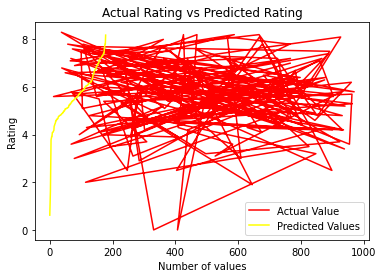

In [48]:
plt.plot(y_test['rating'], color='red', label = 'Actual Value')
plt.plot(y_pred_rating, color='yellow', label='Predicted Values')
plt.title('Actual Rating vs Predicted Rating')
plt.xlabel('Number of values')
plt.ylabel('Rating')
plt.legend()
plt.show()

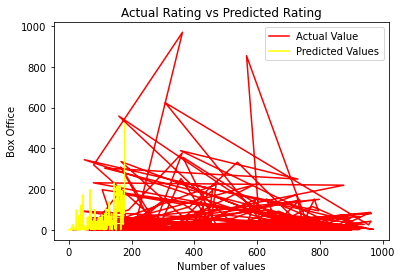

In [49]:
plt.plot(y_test['box office'], color='red', label = 'Actual Value')
plt.plot(y_pred_boxOffice, color='yellow', label='Predicted Values')
plt.title('Actual Rating vs Predicted Rating')
plt.xlabel('Number of values')
plt.ylabel('Box Office')
plt.legend()
plt.show()

# Decision Tree Regression

In [50]:
from sklearn.tree import DecisionTreeRegressor



model = DecisionTreeRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
y_pred

array([[6.2000e+00, 4.1200e+00],
       [4.6000e+00, 4.3200e+00],
       [6.8000e+00, 5.0000e+00],
       [8.4000e+00, 2.1000e+03],
       [6.9000e+00, 4.0000e+00],
       [8.0000e+00, 1.9300e+02],
       [5.6000e+00, 2.4520e+01],
       [8.2000e+00, 1.5732e+02],
       [6.3000e+00, 4.0171e+02],
       [8.0000e+00, 2.4100e+00],
       [5.9000e+00, 8.4000e+01],
       [5.0000e+00, 1.5700e+01],
       [6.5000e+00, 5.0000e+00],
       [5.1000e+00, 3.4276e+02],
       [5.2000e+00, 2.8410e+01],
       [3.9000e+00, 2.5300e+00],
       [5.3000e+00, 2.5041e+02],
       [7.2000e+00, 4.8000e+01],
       [6.3000e+00, 3.1900e+00],
       [8.1000e+00, 5.2500e+00],
       [4.1000e+00, 2.2670e+01],
       [5.3000e+00, 5.0000e-02],
       [6.6000e+00, 9.3000e+01],
       [7.3000e+00, 3.0000e+01],
       [4.3000e+00, 3.7500e+00],
       [2.9000e+00, 7.5500e+00],
       [7.0000e+00, 5.0840e+01],
       [5.9000e+00, 2.5700e+00],
       [5.9000e+00, 2.5700e+00],
       [5.7000e+00, 1.2700e+01],
       [5.

In [51]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([  1.65770301, 192.14066633])

In [52]:
y_test.std()

rating          1.539226
box office    134.060719
dtype: float64

In [53]:
y_pred_rating = []
for i in y_pred:
  y_pred_rating.append(i[0])

y_pred_boxOffice = []
for i in y_pred:
  y_pred_boxOffice.append(i[1])
  

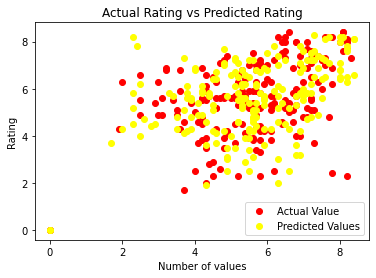

In [54]:
plt.scatter(y_test['rating'], y_pred_rating, color='red', label = 'Actual Value')
plt.scatter(y_pred_rating, y_test['rating'], color='yellow', label='Predicted Values')
plt.title('Actual Rating vs Predicted Rating')
plt.xlabel('Number of values')
plt.ylabel('Rating')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (193,) and (961,)

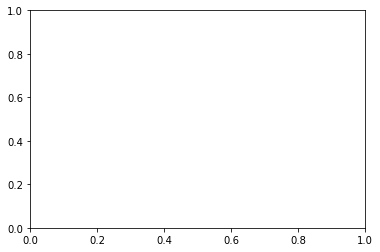

In [55]:
plt.plot(y_test['box office'], genres_df['year'], color='red', label = 'Actual Value')
plt.plot(y_pred_boxOffice, genres_df['year'], color='yellow', label='Predicted Values')
plt.title('Actual Rating vs Predicted Rating')
plt.xlabel('Number of values')
plt.ylabel('Box Office')
plt.legend()
plt.show()